# Importing all the necessairy packages and initialising our identity

The SEC wants us to tell them who we are in order to process our request.

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import datetime
import difflib

# This part I want to figure out if I can get the data from the json files of SEC API.

https://www.sec.gov/edgar/sec-api-documentation

This API is created by the SEC to make finding the data we want much easier. It uses **XBRL** data APIs, starting from 2009 which will give the data some structure. 

The thing about this API is, that the data is structure in a json file. For Python this means there are a lot of nested dictionaris. So we will need to find the right data, inside the nested environment



In [3]:
#set my identity for the SEC (First name last name and email)
name = "Maseeh"
surname = "Faizan"
email = "maseehfaizan@gmail.com"
headers = {'User-Agent':f'{name} {surname} {email}'}

#### First how ever we need to scrape all of the company information like:
- Name
- Ticker
- cik (unique identifier code). cik code needs to be **10 digits with leading zeros**

In what follows I will define a pandas dataframe *ticker_df* to have all of the information on the identifier in the same place

In [4]:
ticker = requests.get('https://www.sec.gov/files/company_tickers.json',headers=headers).json()
ticker_df = pd.DataFrame.from_dict(ticker,orient='index')
ticker_df.rename(columns={'cik_str':'cik','title':'name'},inplace=True)
#Filing in the cik code and adding the leading zeros
ticker_df['cik'] = ticker_df['cik'].astype(str).str.zfill(10)
ticker_df.head()

,cik,ticker,name
0,0000789019,MSFT,MICROSOFT CORP
1,0000320193,AAPL,Apple Inc.
2,0001045810,NVDA,NVIDIA CORP
3,0001652044,GOOGL,Alphabet Inc.
4,0001018724,AMZN,AMAZON COM INC


### Now I need to ask for the ticker name and with that will find out the cik name and everything else
##### Moreover, I need to add leading zeros making the cik number a total of 10, as suggested in the documentation

In [5]:
# I need to find the cik code given the company ticker lets take AAPL as an example 
tic = 'AAPL'
cik = ticker_df.loc[ticker_df['ticker'] == tic, 'cik'].iloc[0]
print(cik)

0000320193


### First let's get our data given the cik value of the company. 

- **submission file**, contains all of the meta data 
Let's see what is in the submission files

It apears to be an embeded dictionary with different infrormation.
After some random information, like website and category we have filings, and in the key of filings there is an embeded dictionary, in which we will find further information about the accounts we are looking for

Let's see what is inside it:


In [6]:
files = requests.get(f'https://data.sec.gov/submissions/CIK{cik}.json',headers=headers).json()
files.keys()

dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])

We fine a column of recent and a column of files and recent. 
- Files is a dead end. 
For now I want to look into the recent submissions and try to turn the dictionary into Pandas DataFrame. This contain the file, number the kind of form it is, accessionNumber code. Handy information to move forward with

In [7]:
files['filings'].keys()

dict_keys(['recent', 'files'])

In [8]:
files['filings']['recent'].keys()

dict_keys(['accessionNumber', 'filingDate', 'reportDate', 'acceptanceDateTime', 'act', 'form', 'fileNumber', 'filmNumber', 'items', 'size', 'isXBRL', 'isInlineXBRL', 'primaryDocument', 'primaryDocDescription'])

### Here I have all of the forms and I only need the 10Ks for now to find the Balance Sheet and other Financial statemnts. 

I am taking all the recent submissions and turning it into a **Pandas Dataframe** then I specifically want the **10K** to be used as anual information. 

I now have information like
- 10-K form
- filing date
- it's primary Document
- XBRL information


In [9]:
recent_files = pd.DataFrame(files['filings']['recent'])
tenk =recent_files[recent_files['form'] == '10-K']
tenk.head(3)

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
51,0000320193-23-000106,2023-11-03,2023-09-30,2023-11-02T18:08:27.000Z,34,10-K,001-36743,231373899,,9569569,1,1,aapl-20230930.htm,10-K
129,0000320193-22-000108,2022-10-28,2022-09-24,2022-10-27T18:01:14.000Z,34,10-K,001-36743,221338448,,10332356,1,1,aapl-20220924.htm,10-K
204,0000320193-21-000105,2021-10-29,2021-09-25,2021-10-28T18:04:28.000Z,34,10-K,001-36743,211359752,,10502096,1,1,aapl-20210925.htm,10-K


### Now that I have all this information, I can simply use them to find the kind of data I am actually looking for (Financial information)

- I will use the data in the dataframe above and find the company facts that is organised using the **SEC XBRL *API*** 

Here we have three keys, 
- cik 
- company name 
- facts. 

Let's look into facts

In [10]:
facts = requests.get(f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json',headers = headers).json()
facts.keys()

dict_keys(['cik', 'entityName', 'facts'])

#### In company's facts we have dei code and US-GAAP. In dei we have public shares outstanding data. What we are interested in is us-gaap which has list of all the balance sheed and income statement information

In [11]:
facts['facts'].keys()

dict_keys(['dei', 'us-gaap'])

In [12]:
facts['facts']['us-gaap'].keys()

dict_keys(['AccountsPayable', 'AccountsPayableCurrent', 'AccountsReceivableNetCurrent', 'AccruedIncomeTaxesCurrent', 'AccruedIncomeTaxesNoncurrent', 'AccruedLiabilities', 'AccruedLiabilitiesCurrent', 'AccruedMarketingCostsCurrent', 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment', 'AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue', 'AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation', 'AdvertisingExpense', 'AllocatedShareBasedCompensationExpense', 'AllowanceForDoubtfulAccountsReceivableCurrent', 'AmortizationOfIntangibleAssets', 'AntidilutiveSecuritiesExcludedFromCompu

Here I am calling the variable **accounts** the name of the accounts that are at my disposal in the SEC.

- I am going to normalize the naming process for both [accounts and names] list. Remove any capital letter, dots or spaces there might be. 

- I am then going to create a dictionary. The **keys** are the name of the accounts and the **value** will be the name that is present are present in most of the **10K**. There are different accounts and different naming schemes for the same accounts given different countries. My code needs to work for most of the companies. I have gone through dosens of them and have come up with the most common naming schemes.


Furthermore, I am also taking the most common accounts, like Assets, Liability, Revenues COGS. These are the accounts we care about the most and these are also accounts that are commun accross different companies.


I have shyed away from specific accounts, like Amazon has Fulfillment account, Apple has PPE, but then Pfizer has very different accounts. I can't possibliy account for all those different variation **FOR NOW** 

In [13]:

accounts = list(facts['facts']['us-gaap'].keys())

# Normalize everything down
normalized_account = [re.sub(r'\W+', '',s).lower() for s in accounts]

names = {'Assets':['Assets'],
        'Current Assets':['assets current'],
        'Cash':['Cash and cash equivalents'],
        'Current Liability':['Liability current'],
        'Total Stockholders equity':['Stockholders Equity'],
        'Liability and Stockholder equity':['Liabilities and Stockholders equity'],
        'Revenues':['Sales'],
        'COGS':['Cost of Goods Sold'],
        'Operating Expense':['Total Operating Expense'],
        'Net Income':['Net Income'],
        'EPS':['Earnings Per Share basic']
        }

## Before matching both lists [accounts names] 
I would first need to normalize both, so the mathching process is efficient. Because many companies use different account names, I used **difflib** library to help me find the best match for each account. I have tried it with dosens of account and it is working fine for now. There might be some bugs here and there, for some campanies that the code doesn't account for. For those cases the code needs to be run on a **beta phase** to find those issues and fix them 

In [14]:
# find the best match between the names dictionary and the list I have in the accounts
def find_best_match(items, search):
    matches = difflib.get_close_matches(search, items, n=1, cutoff=0.0)
    return matches[0] if matches else None

for key, value in names.items():
    value = [re.sub(r'\W+', '',s).lower() for s in value]
    best_match = [find_best_match(normalized_account, j) for j in value]
    
    accounts_match = [find_best_match(accounts, best_match[0])]
    names[key] = accounts_match[0]
names

{'Assets': 'Assets',
 'Current Assets': 'AssetsCurrent',
 'Cash': 'CashAndCashEquivalentsAtCarryingValue',
 'Current Liability': 'LiabilitiesCurrent',
 'Total Stockholders equity': 'StockholdersEquity',
 'Liability and Stockholder equity': 'LiabilitiesAndStockholdersEquity',
 'Revenues': 'SalesRevenueNet',
 'COGS': 'CostOfGoodsAndServicesSold',
 'Operating Expense': 'OperatingExpenses',
 'Net Income': 'NetIncomeLoss',
 'EPS': 'EarningsPerShareBasic'}

## Creating financials pandas dataframe that will contain the necessairy information. 
First I ceate the data frame. I then run through the whole dictinary. The key will be the **name** of the account and the value, that were found using best match will be the information contained in different columns.
To comply with SEC documentation I am putting a timer on how many times per second the code can run and ask relative information of different accounts

To fetch those information, I need the company **cik** code and the account name, which is the **value** of the account. 

Furthermore, the unit in Earnings Per Share account is **USD/Share** and not **USD** so I need to take care of that.

I also want the financial accounts to take the indices of the most complete account which is the **Assets account** that is why I have **ix** variable set to **0**. When ix != 0 I continue as usual merging accounts together. 

Finally I want the columns indices to be the years I have at hand, and the row indecis the account names so I transpose those accounts

In [15]:
financials = pd.DataFrame(columns=['Year','val'])
ix = 0
for key,value in names.items():
    # To comply with SEC we need to set a timer so the program doesn't request too many items at once
    time.sleep(0.12)
    name = key
    company_concept = requests.get(f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/{value}.json',headers=headers).json()
    # the unit for Earning per share is USD/Share and not USD which means I need to adapt the code for that
    if key == 'EPS':
        name = pd.DataFrame(company_concept['units']['USD/shares'])
    else:
        name = pd.DataFrame(company_concept['units']['USD'])
    name = name[name['form'] == '10-K']
    name = name.drop_duplicates(subset='fy',keep='last')
    name = name.tail(60)
    name = name[['fy','val']]
    name = name.rename(columns={'fy':'Year','val':key})
    # I want to initialize the balance sheet that is why I need to merge on name, then after I will merge on Balance Sheet dataframe
    if ix == 0:
        financials = financials.merge(name,left_on='Year',right_on='Year',how='right')
        ix +=1
    else:
        financials = financials.merge(name,left_on='Year',right_on='Year',how='left')

financials = financials.drop('val',axis = 1)
financials = financials.sort_values(by='Year',ascending=False)
financials = financials.set_index('Year')
financials = financials.T

In [16]:
financials.head(3)

Year,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009
Assets,3.525830e+11,3.527550e+11,3.510020e+11,3.238880e+11,3.385160e+11,3.657250e+11,3.753190e+11,3.216860e+11,2.904790e+11,2.318390e+11,2.070000e+11,1.760640e+11,1.163710e+11,7.518300e+10,5.385100e+10
Current Assets,1.435660e+11,1.354050e+11,1.348360e+11,1.437130e+11,1.628190e+11,1.313390e+11,1.286450e+11,1.068690e+11,8.937800e+10,6.853100e+10,7.328600e+10,5.765300e+10,4.498800e+10,4.167800e+10,3.626500e+10
Cash,2.996500e+10,2.364600e+10,3.494000e+10,3.801600e+10,4.884400e+10,2.591300e+10,2.028900e+10,2.048400e+10,2.112000e+10,1.384400e+10,1.425900e+10,1.074600e+10,9.815000e+09,1.126100e+10,5.263000e+09


In [17]:
income = financials.iloc[6:].transpose()

balance = financials.iloc[:6].transpose()


income.reset_index(inplace=True)
balance.reset_index(inplace=True)

In [18]:
balance.head(10)

,Year,Assets,Current Assets,Cash,Current Liability,Total Stockholders equity,Liability and Stockholder equity
0,2023,3.525830e+11,1.435660e+11,2.996500e+10,1.453080e+11,6.214600e+10,3.525830e+11
1,2022,3.527550e+11,1.354050e+11,2.364600e+10,1.539820e+11,5.067200e+10,3.527550e+11
2,2021,3.510020e+11,1.348360e+11,3.494000e+10,1.254810e+11,6.309000e+10,3.510020e+11
3,2020,3.238880e+11,1.437130e+11,3.801600e+10,1.053920e+11,6.533900e+10,3.238880e+11
4,2019,3.385160e+11,1.628190e+11,4.884400e+10,1.057180e+11,9.048800e+10,3.385160e+11
5,2018,3.657250e+11,1.313390e+11,2.591300e+10,1.168660e+11,1.071470e+11,3.657250e+11
6,2017,3.753190e+11,1.286450e+11,2.028900e+10,1.008140e+11,1.340470e+11,3.753190e+11
7,2016,3.216860e+11,1.068690e+11,2.048400e+10,7.900600e+10,1.282490e+11,3.216860e+11
8,2015,2.904790e+11,8.937800e+10,2.112000e+10,8.061000e+10,1.193550e+11,2.904790e+11
9,2014,2.318390e+11,6.853100e+10,1.384400e+10,6.344800e+10,1.115470e+11,2.318390e+11


### Now that I have the financial data from SEC, I will look into Yahoo Finance to find the stock data.

To match with Financials data I will download data for the same years as those accounts

In [19]:
first = financials.columns[0].astype(int)
last = financials.columns[-1].astype(int)

start=datetime.datetime(last,1,1)
end=datetime.datetime(first,12,31)

price = yf.download(tic,start,end)
market = yf.download('^GSPC',start,end)

price.reset_index(inplace=True)
market.reset_index(inplace=True)

price['Average'] = (price['High'] + price['Low']) / 2
price = price[['Date','Average','Volume']]

market['Average'] = (market['High'] + market['Low']) / 2
market = market[['Date','Average','Volume']]

# Convert 'date' to datetime
price['Date'] = pd.to_datetime(price['Date'])

price = price.rename(columns={'Average':f'{tic} Price','Volume':f'{tic} Volume'})
market = market.rename(columns={'Average':'S&P500','Volume':'S&P500 Volume'})


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [20]:
price.head()

,Date,AAPL Price,AAPL Volume
0,2009-01-02,3.146429,746015200
1,2009-01-05,3.373035,1181608400
2,2009-01-06,3.385000,1289310400
3,2009-01-07,3.263571,753048800
4,2009-01-08,3.271250,673500800


In [21]:
main = pd.merge(price,market,right_on='Date',left_on='Date',how='inner')

In [22]:
main.head()

,Date,AAPL Price,AAPL Volume,S&P500,S&P500 Volume
0,2009-01-02,3.146429,746015200,917.039978,4048270000
1,2009-01-05,3.373035,1181608400,928.080017,5413910000
2,2009-01-06,3.385000,1289310400,935.565002,5392620000
3,2009-01-07,3.263571,753048800,914.910004,4704940000
4,2009-01-08,3.271250,673500800,903.404999,4991550000


In [23]:


# Plot the data
price['Average'].plot()


# Label the axes
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend Over Time')

# Show the plot
plt.show()

KeyError: 'Average'

/var/folders/3d/sfjwl1qd13g579465zdsgptr0000gn/T/ipykernel_23080/2692178642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['DateNum'] = mdates.date2num(market['Date'])


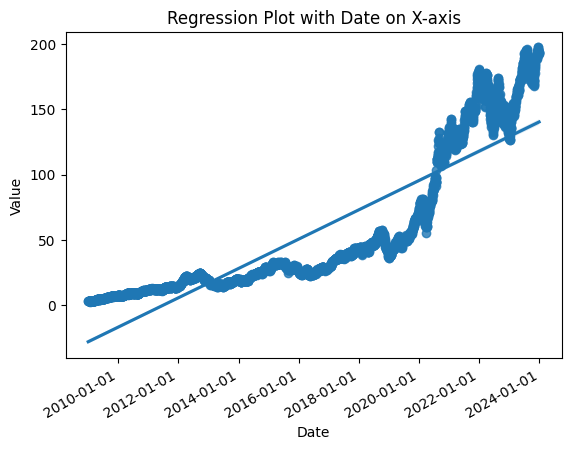

In [ ]:
market['DateNum'] = mdates.date2num(market['Date'])
price['DateNum'] = mdates.date2num(price['Date'])
sns.regplot(x='DateNum', y='Average', data=price)

# Set up the plot to interpret the numerical dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Improve plot appearance
plt.gcf().autofmt_xdate()  # Rotate date labels to fit better

plt.title('Regression Plot with Date on X-axis')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


<Axes: xlabel='Year', ylabel='Assets'>

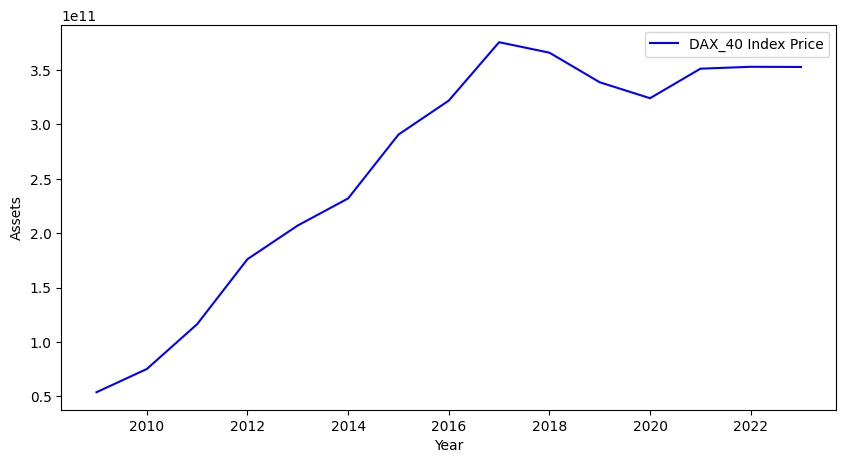

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x='Year', y='Assets', data= balance, ax=ax,
             label='Assets', color='blue')